In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [2]:
data = pd.read_excel('Property Data Compiled.xlsx', index_col = 0)

In [3]:
data.shape

(20363, 211)

In [4]:
cols = ['PropertyID', 
        # rent fields
        'Avg Effective/SF', 'Avg Concessions %',
        'Studio Effective Rent/SF', 'One Bedroom Effective Rent/SF', 'Two Bedroom Effective Rent/SF',
        'Three Bedroom Effective Rent/SF', 'Four Bedroom Effective Rent/SF',
        # unit fields
        'Studio Avg SF', 'Number Of Studios', 'Studio Vacant Units', 'Studio Vacancy %',
        'One Bedroom Avg SF','Number Of 1 Bedrooms', 'One Bedroom Vacant Units', 'One Bedroom Vacancy %',
        'Two Bedroom Avg SF', 'Number Of 2 Bedrooms', 'Two Bedroom Vacant Units', 'Two Bedroom Vacancy %',
        'Three Bedroom Avg SF', 'Number Of 3 Bedrooms', 'Three Bedroom Vacant Units', 'Three Bedroom Vacancy %',
        'Four Bedroom Avg SF', 'Number Of 4 Bedrooms', 'Four Bedroom Vacant Units', 'Four Bedroom Vacancy %',        
        # location fields
        'State', 'Market Name', 'City', 'Zip', 'County Name',
        'Closest Transit Stop Dist (mi)', 'Latitude', 'Longitude',
        # property fields
        'Star Rating', 'Building Status', 'Land Area (AC)', 'Number Of Stories',
        'Style', 'Number Of Units', 'Vacancy %', 'Avg Unit SF', 'RBA',
        '% Studios', '% 1-Bed', '% 2-Bed', '% 3-Bed', '% 4-Bed',
        'Rent Type', 'Affordable Type', 'Market Segment', 
        'Amenities', 'Building Class', 'Construction Material', 'Owner Name', 'Property Manager Name',
        'Year Built', 'Year Renovated',
        # demographic fields
        '2019 Avg Age(1m)', '2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)','2019 Pop Age 65+(1m)']
sub = data.copy()[cols]
sub.drop_duplicates(subset='PropertyID', inplace = True)
sub['State'] = sub['State'].replace('Fl', 'FL').replace('NC ','NC')
sub['Zip5'] = sub['Zip'].str[:5]
sub.shape

(20300, 65)

In [5]:
sub['Avg Effective/SF'].describe()

count    16751.000000
mean         1.258938
std          0.555898
min          0.190000
25%          0.970000
50%          1.160000
75%          1.400000
max         14.030000
Name: Avg Effective/SF, dtype: float64

In [6]:
print('99% quantile:',sub['Avg Effective/SF'].quantile(0.99))

99% quantile: 3.47


# 0 Import Income, Marriage and Deposit data

In [7]:
demo = pd.read_csv('income_marriage.csv')

In [8]:
demo['Zip5'] = demo['Zip5'].apply(round).astype(str)
demo.shape

(1925, 4)

In [9]:
sub = sub.merge(demo, how='left', on='Zip5')
sub.shape

(20300, 68)

In [10]:
deposit = pd.read_csv('per_capita_deposit.csv')

In [11]:
deposit.rename(columns={'County':'County Name'}, inplace=True)

In [12]:
deposit.shape

(572, 5)

In [13]:
sub = sub.merge(deposit[['State', 'County Name', 'Deposit (000s) Per Capita']], 
               on=['State', 'County Name'], how='left')
sub.shape

(20300, 69)

# 1 Rent by Unit Type

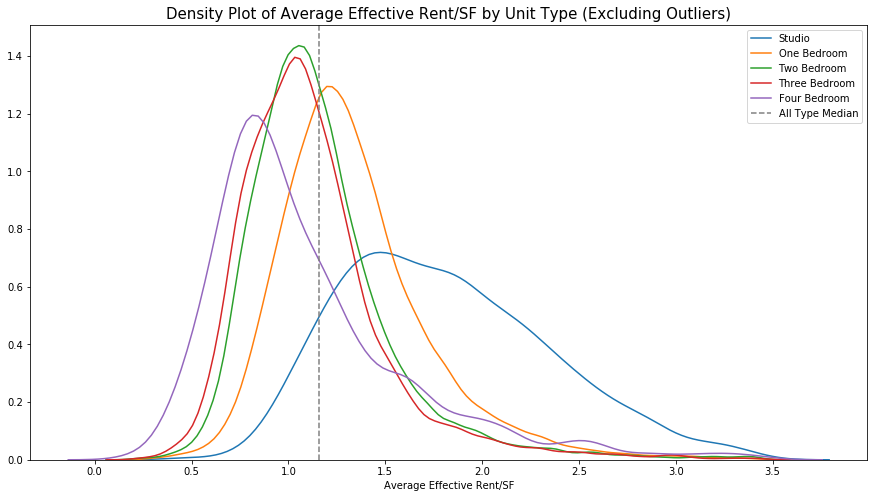

In [14]:
unit_rent = ['Studio', 'One Bedroom', 'Two Bedroom',
             'Three Bedroom', 'Four Bedroom']

plt.figure(figsize=(15,8))
for unit in unit_rent:   
    df = sub[sub['{} Effective Rent/SF'.format(unit)]<sub['Avg Effective/SF'].quantile(0.99)]\
    ['{} Effective Rent/SF'.format(unit)]
    sns.distplot(df, hist=False, label=unit)
#dist.set_title('Density Plot of Average Effective Rent/SF by {} (Excluding 1% Outliers)'.format(cat), fontsize=15)
#dist.set_xlabel('Average Effective Rent/SF')
#sns.distplot(sub[sub['Avg Effective/SF']<sub['Avg Effective/SF'].quantile(0.99)]['Avg Effective/SF'], 
#             hist=False, label='All Type', kde_kws=dict(linewidth=3, color='black', linestyle='--'))
plt.axvline(sub['Avg Effective/SF'].median(), color='grey', linestyle='--', label='All Type Median')
plt.xlabel('Average Effective Rent/SF')
plt.title('Density Plot of Average Effective Rent/SF by Unit Type (Excluding Outliers)', fontsize=15)
plt.legend()
plt.show()

# 2 Categorical Variables

In [15]:
def get_summary(cat):
    sub[cat] = sub[cat].fillna('Unspecified')
    summary = pd.DataFrame(sub.groupby(cat)['Avg Effective/SF'].\
                           mean().reset_index(name='Mean'))
    summary = summary.merge(pd.DataFrame(sub.groupby(cat)['Avg Effective/SF'].\
                                         median().reset_index(name='Median')))
    summary = summary.merge(pd.DataFrame(sub.groupby(cat)['PropertyID'].\
                                         count().reset_index(name='Count')))
    summary['Pct'] = summary['Count']/summary['Count'].sum()
    summary = summary.sort_values('Median', ascending=False)
    summary['label'] = summary.apply(lambda x: x[0]+' '+str(x[3])+'\n('+str(round(x[4]*100,1))+'%)', axis=1)
    return summary

In [16]:
def create_plot(cat):
    summary = get_summary(cat)
    
    fig = plt.figure(figsize=(18,12))

    # Set up grid
    grid = plt.GridSpec(2, 2, wspace = 0.1, hspace = 0.2)
    tree = fig.add_subplot(grid[0,0])
    bar = fig.add_subplot(grid[0,1])
    dist = fig.add_subplot(grid[1,0:2])

    # Tree map
    colors= plt.get_cmap('Spectral')(np.linspace(0,1,summary.shape[0]))
    squarify.plot(sizes=summary['Count'],label=summary['label'], color=colors,alpha=0.6, ax=tree,
                  text_kwargs={'fontsize':12})
    tree.axis('off')
    tree.set_title('Number of Properties by {}'.format(cat), fontsize=15)

    # Bar chart
    pos = np.arange(summary.shape[0])
    barwidth = 0.3
    bar.bar(pos-barwidth/2, summary['Mean'], width=barwidth, label='Mean')
    bar.bar(pos+barwidth/2, summary['Median'], width=barwidth, label='Median')
    ymax = round((summary['Mean'].max()+0.2),2)
    bar.set_ylim(0,ymax)
    #bar.set_yticks(np.arange(0,1.6,0.2))
    bar.set_xticks(pos)
    bar.set_xticklabels(summary[cat])
    bar.axhline(sub['Avg Effective/SF'].median(),
                color='orange', linestyle='--',
                label='All Property Median')
    bar.legend(loc=1)
    bar.set_title('Mean dnd Median Average Effective Rent/SF by {}'.format(cat), fontsize=15)
    bar.set_ylabel('Average Effective Rent/SF')

    # Density plot
    for value in sub[cat].unique():   
        df = sub[(sub[cat]==value) & \
                 (sub['Avg Effective/SF']<sub['Avg Effective/SF'].quantile(0.99))]['Avg Effective/SF']
        sns.distplot(df, hist=False, label=value, ax=dist)
    dist.set_title('Density Plot of Average Effective Rent/SF by {} (Excluding 1% Outliers)'.format(cat), fontsize=15)
    dist.set_xlabel('Average Effective Rent/SF')

    fig.suptitle('Rent vs {}'.format(cat), fontsize=25)

    plt.show()

### 2.1 State

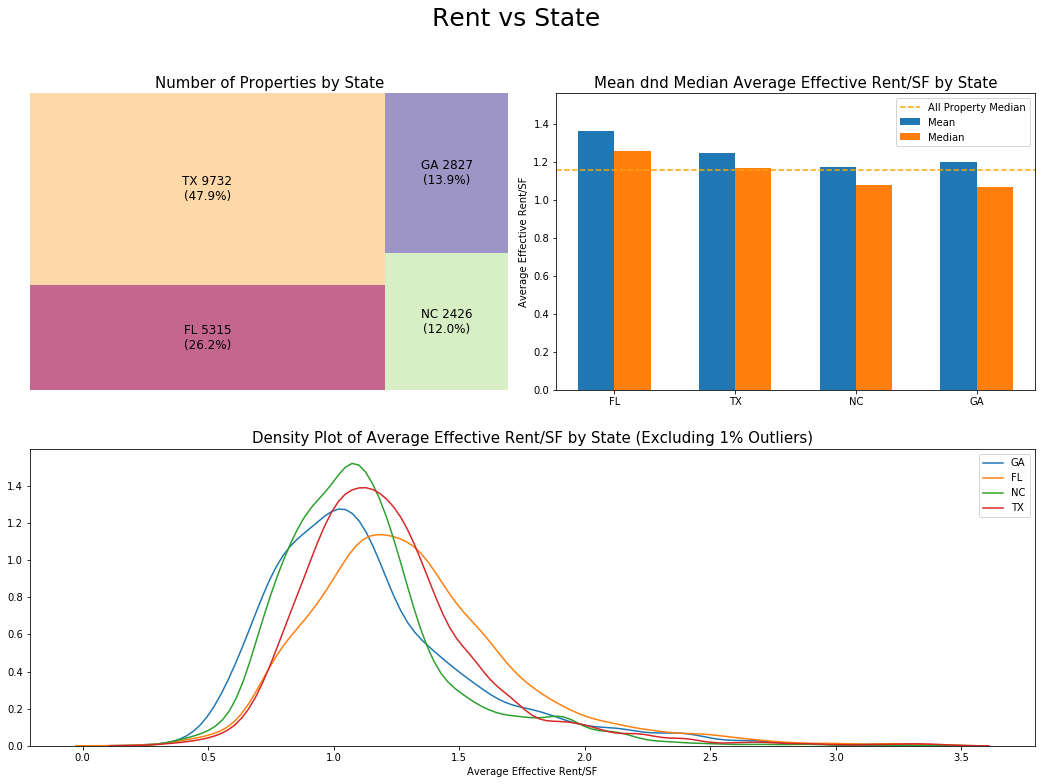

In [17]:
cat = 'State'
create_plot(cat)

### 2.2 Construction Material

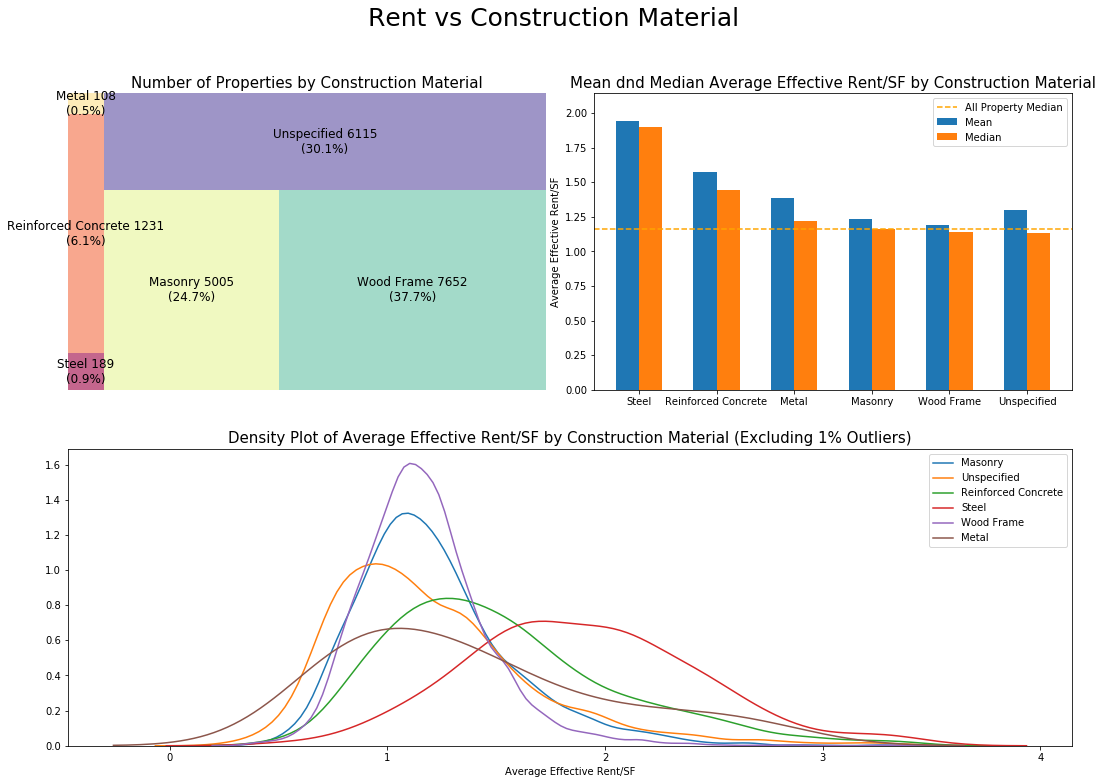

In [18]:
cat = 'Construction Material'
create_plot(cat)

### 2.3 Star Rating

In [19]:
sub['Star Rating'] = sub['Star Rating'].astype(str)

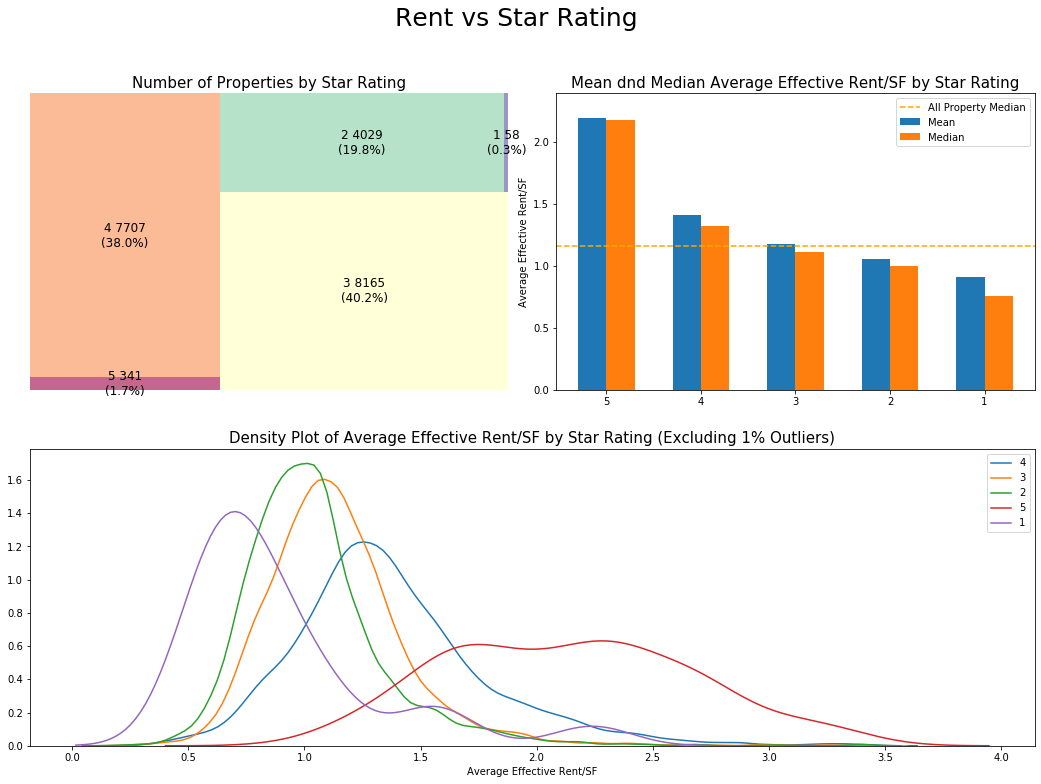

In [20]:
cat = 'Star Rating'
create_plot(cat)

### 2.4 Building Class

In [21]:
cat = 'Building Class'
summary = get_summary(cat)
summary = summary[summary['Building Class']!='Unspecified']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


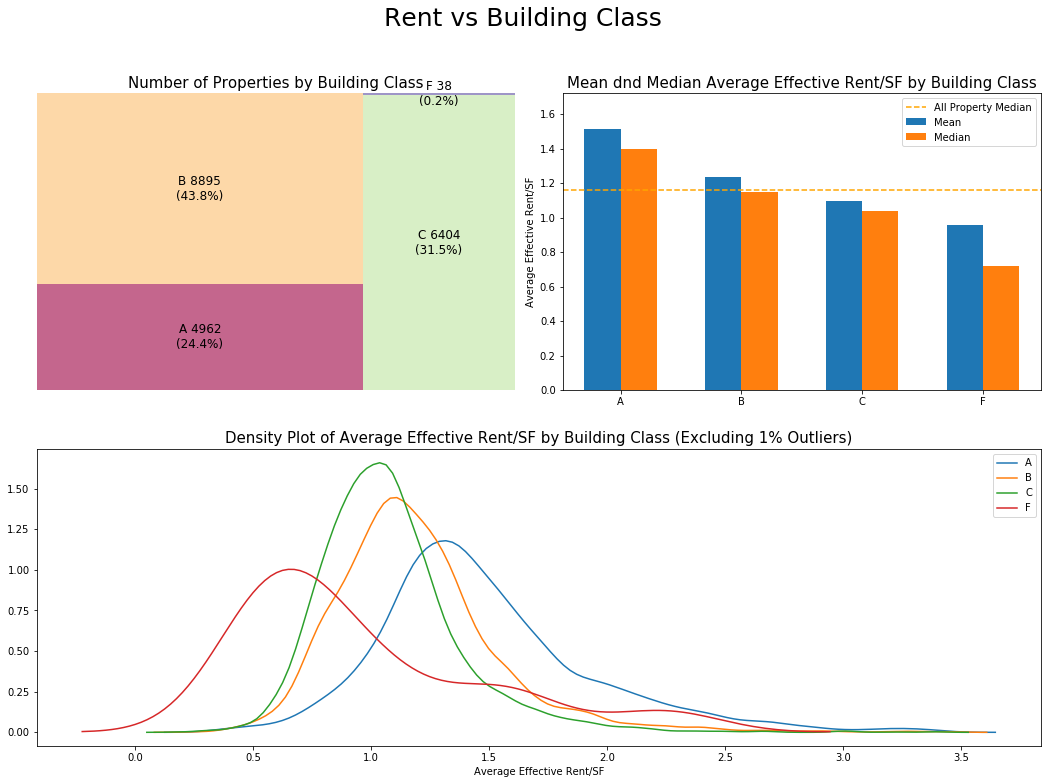

In [22]:
fig = plt.figure(figsize=(18,12))

# Set up grid
grid = plt.GridSpec(2, 2, wspace = 0.1, hspace = 0.2)
tree = fig.add_subplot(grid[0,0])
bar = fig.add_subplot(grid[0,1])
dist = fig.add_subplot(grid[1,0:2])

# Tree map
colors= plt.get_cmap('Spectral')(np.linspace(0,1,summary.shape[0]))
squarify.plot(sizes=summary['Count'],label=summary['label'], color=colors,alpha=0.6, ax=tree,
              text_kwargs={'fontsize':12})
tree.axis('off')
tree.set_title('Number of Properties by {}'.format(cat), fontsize=15)

# Bar chart
pos = np.arange(summary.shape[0])
barwidth = 0.3
bar.bar(pos-barwidth/2, summary['Mean'], width=barwidth, label='Mean')
bar.bar(pos+barwidth/2, summary['Median'], width=barwidth, label='Median')
ymax = round((summary['Mean'].max()+0.2),2)
bar.set_ylim(0,ymax)
#bar.set_yticks(np.arange(0,1.6,0.2))
bar.set_xticks(pos)
bar.set_xticklabels(summary[cat])
bar.axhline(sub['Avg Effective/SF'].median(),
            color='orange', linestyle='--',
            label='All Property Median')
bar.legend(loc=1)
bar.set_title('Mean dnd Median Average Effective Rent/SF by {}'.format(cat), fontsize=15)
bar.set_ylabel('Average Effective Rent/SF')

# Density plot
for value in sub[cat].unique():   
    df = sub[(sub[cat]==value) & \
             (sub['Avg Effective/SF']<sub['Avg Effective/SF'].quantile(0.99))]['Avg Effective/SF']
    sns.distplot(df, hist=False, label=value, ax=dist)
dist.set_title('Density Plot of Average Effective Rent/SF by {} (Excluding 1% Outliers)'.format(cat), fontsize=15)
dist.set_xlabel('Average Effective Rent/SF')

fig.suptitle('Rent vs {}'.format(cat), fontsize=25)

plt.show()

### 2.5 Star Rating vs Building Class

In [23]:
classes = {}
for i in sub['Building Class'].unique():
    name = '{}'.format(i)
    classes[name] = sub[sub['Building Class']==i]['Star Rating'].astype(int)

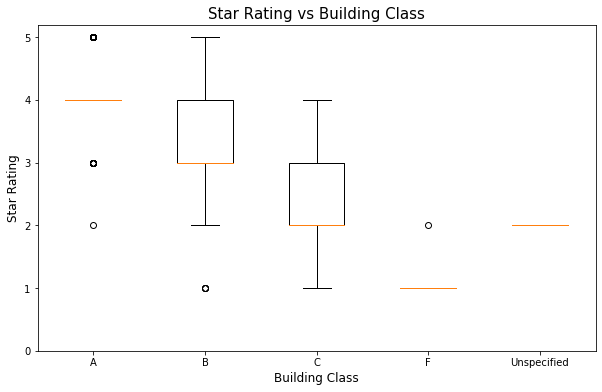

In [24]:
plt.figure(figsize=(10,6))
plt.boxplot(classes.values(), labels=classes.keys())
plt.title("Star Rating vs Building Class", fontsize=15)
plt.xlabel("Building Class", fontsize=12)
plt.ylabel("Star Rating",fontsize=12)
plt.yticks(np.arange(0,5.5,1))
plt.show()

### 2.6 Affordable type
- Rent Controlled & Rent Stabilized combined in Rent Restricted

In [25]:
sub['Rent Type'].fillna('Unspecified', inplace=True)
sub['Affordable Type'].fillna(sub['Rent Type'], inplace=True)
sub.loc[sub['Affordable Type']=='Affordable', 'Affordable Type'] = 'Unspecified'
sub.loc[sub['Affordable Type']=='Market/Affordable', 'Affordable Type'] = 'Unspecified'
sub.loc[sub['Affordable Type']=='Rent Stabilized', 'Affordable Type'] = 'Rent Restricted'
sub.loc[sub['Affordable Type']=='Rent Controlled', 'Affordable Type'] = 'Rent Restricted'

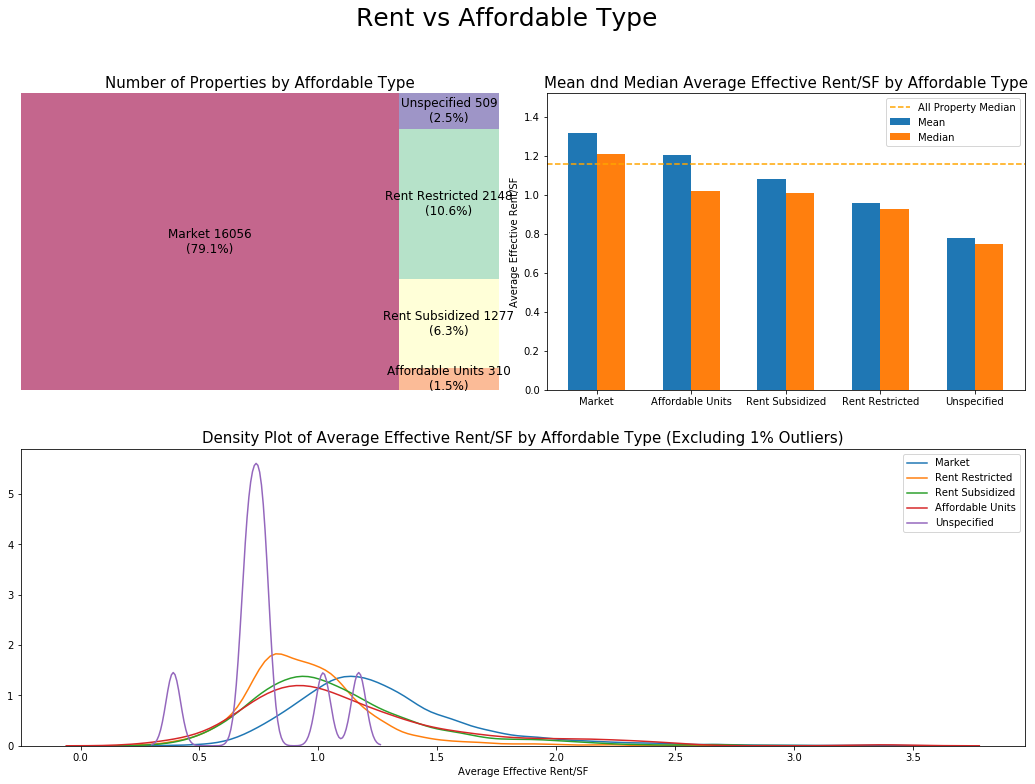

In [26]:
cat = 'Affordable Type'
create_plot(cat)

### 2.7 Owner type
- Large owner: manages >=50 properties
- Medium owner: manages [10,50) properties
- Small owner: manages <10 properties or unspecified owner

In [27]:
owner = sub['Owner Name'].value_counts().reset_index(name='count')
print('large owner:', owner[owner['count']>=50].shape[0])
print('medium owner:', owner[(owner['count']>=10) & (owner['count']<50)].shape[0])
print('small owner:', owner[owner['count']<10].shape[0])

large owner: 20
medium owner: 363
small owner: 6733


In [28]:
large_owner = owner[owner['count']>=50]['index'].tolist()
medium_owner = owner[(owner['count']>=10) & (owner['count']<50)]['index'].tolist()
small_owner = owner[owner['count']<10]['index'].tolist()

In [29]:
sub['Owner Type'] = sub['Owner Name'].apply(lambda x: 'large' if x in large_owner else(
                                        'medium' if x in medium_owner else 'small'))
sub['Owner Type'].value_counts()

small     12137
medium     6560
large      1603
Name: Owner Type, dtype: int64

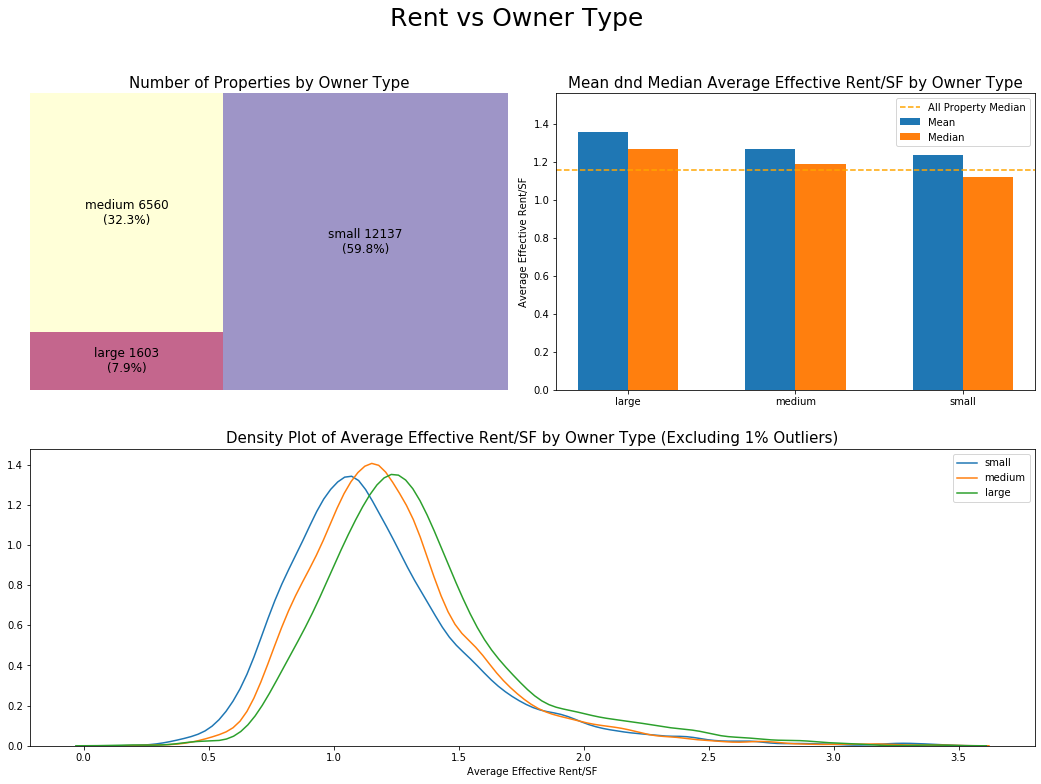

In [30]:
cat = 'Owner Type'
create_plot(cat)

### 2.8 Amenities

In [31]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

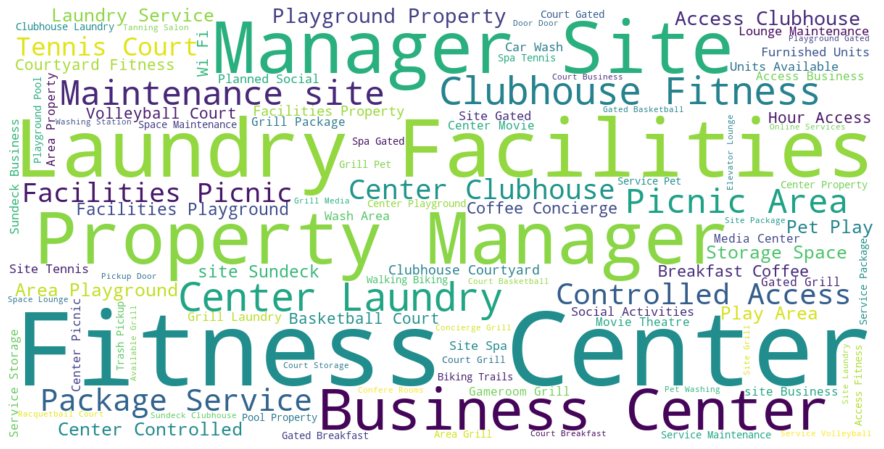

In [50]:
text = " ".join(amenity for amenity in sub.Amenities.dropna())
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white",
                     width=1200, height=600).generate(text)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
amenities = {}
all_amenities = sub[sub['Amenities'].notnull()]['Amenities'].str.split(', ').tolist()
for row in all_amenities:
    #print(row)
    for item in row:
        #print(item)
        if item not in amenities.keys():
            amenities[item] = 1
        else:
            amenities[item] += 1
len(amenities)

94

In [34]:
amenity_vs_rent = pd.DataFrame()

sub2 = sub[sub['Amenities'].notnull()]

for amenity in amenities:
    yes = sub2[sub2['Amenities'].str.contains(amenity)]['Avg Effective/SF'].mean()
    no = sub2[-sub2['Amenities'].str.contains(amenity)]['Avg Effective/SF'].mean()
    count = sub2[sub2['Amenities'].str.contains(amenity)]['Avg Effective/SF'].count()
    amenity_vs_rent = amenity_vs_rent.append(pd.DataFrame([amenity,count,yes,no,yes-no]).T,
                                             ignore_index=True)

amenity_vs_rent.columns = ['amenity','count','yes', 'no', 'diff']
amenity_vs_rent = amenity_vs_rent.sort_values('diff')

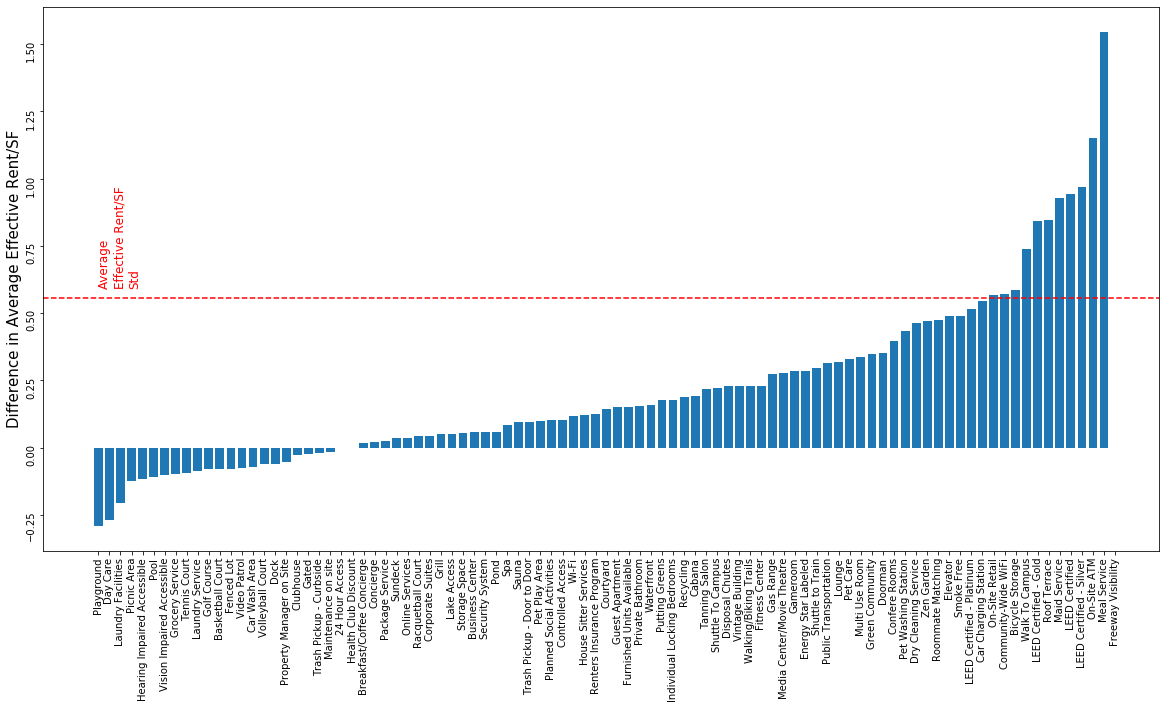

In [35]:
test = amenity_vs_rent[amenity_vs_rent['amenity']!='Study Lounge']

plt.figure(figsize=(20,10))
plt.bar(np.arange(test.shape[0]),
        test['diff'])
plt.xticks(np.arange(test.shape[0]),
           test['amenity'],
           rotation=90)
plt.yticks(rotation=90)
plt.axhline(sub['Avg Effective/SF'].std(),
            color='red',
            linestyle='--')
#plt.title('Average Effective Rent/SF With vs Without Amenity', fontsize=15)
plt.ylabel('Difference in Average Effective Rent/SF', fontsize=15)
plt.annotate('Average\nEffective Rent/SF\nStd', 
             (0,0.6), fontsize=12, color='red',
             rotation=90)
plt.show()

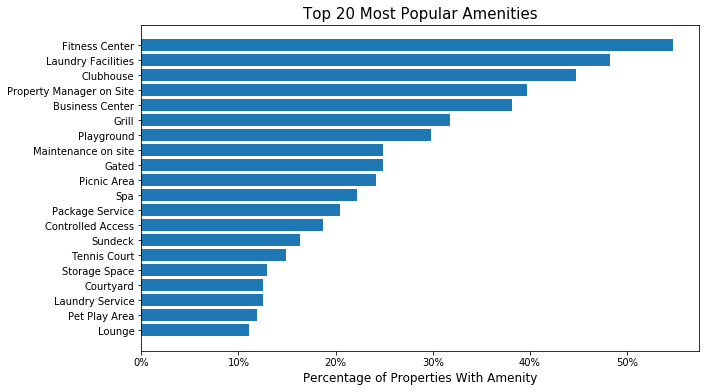

In [36]:
amenity_vs_rent_short = amenity_vs_rent.sort_values('count').tail(20)
amenity_vs_rent_short['pct'] = amenity_vs_rent_short['count']/sub.shape[0]
pos = np.arange(amenity_vs_rent_short.shape[0])
plt.figure(figsize=(10,6))
plt.barh(pos, amenity_vs_rent_short['pct'])
plt.xticks(np.arange(0,0.6,0.1),
           [str(i)+'%' for i in range(0,60,10)])
plt.yticks(pos, amenity_vs_rent_short['amenity'])
plt.title('Top 20 Most Popular Amenities', fontsize=15)
plt.xlabel('Percentage of Properties With Amenity',fontsize=12)
plt.show()

# 3 Numerical Variables

In [37]:
cols = ['Avg Effective/SF', 'Closest Transit Stop Dist (mi)', 'Land Area (AC)', 'Number Of Stories', 
        'Number Of Units', 'Vacancy %', 'Avg Unit SF', 'RBA', 'Year Built', 'Year Renovated',
        'MedanHHIncome(000)', 'married %', 'male/female', '2019 Avg Age(1m)', 'Deposit (000s) Per Capita',
        '2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)','2019 Pop Age 65+(1m)']
numerical = sub[cols]
numerical['Year Renovated'] = numerical['Year Renovated'].fillna(numerical['Year Built'])
numerical['2019 Pop Tot'] = numerical[['2019 Pop Age <19(1m)', '2019 Pop Age 20-64(1m)',
                                      '2019 Pop Age 65+(1m)']].sum(axis=1)
numerical.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(20300, 19)

In [38]:
acre_to_sf = 43560
numerical.loc[numerical['Land Area (AC)'] == numerical['Land Area (AC)'].max(), 'Land Area (AC)'] = \
numerical['Land Area (AC)'].max()/acre_to_sf

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
scaler.fit(numerical)
scaled_numerical = pd.DataFrame(scaler.transform(numerical))
scaled_numerical.columns = numerical.columns

In [41]:
scaled_numerical.head()

,Avg Effective/SF,Closest Transit Stop Dist (mi),Land Area (AC),Number Of Stories,Number Of Units,Vacancy %,Avg Unit SF,RBA,Year Built,Year Renovated,MedanHHIncome(000),married %,male/female,2019 Avg Age(1m),Deposit (000s) Per Capita,2019 Pop Age <19(1m),2019 Pop Age 20-64(1m),2019 Pop Age 65+(1m),2019 Pop Tot
0,0.361699,NaN,-0.171852,-0.100175,-0.264579,-0.335072,1.243410,0.029041,0.650239,0.491091,1.985256,2.023719,-0.083175,-0.103248,1.738689,0.695878,0.466699,-0.178112,0.470115
1,NaN,-0.123263,-0.280836,NaN,0.083632,NaN,0.624718,0.073465,1.438444,1.303403,-0.488398,-1.637035,0.686169,-1.029266,1.738689,0.183433,1.316380,-0.656441,0.853241
2,NaN,0.078472,-0.367047,0.126189,-0.329062,-0.214690,NaN,-0.023871,0.072222,-0.104605,-0.488398,-1.637035,0.686169,-1.161554,1.738689,0.565230,1.836947,-0.731128,1.291466
3,1.531013,-1.401603,-0.334229,0.126189,-0.406443,-0.285327,0.144081,-0.054726,0.282410,0.112011,1.115502,-0.914180,0.452612,0.066837,1.738689,0.982965,2.811152,0.922045,2.264765
4,1.531013,-1.417042,NaN,1.258008,-0.857828,0.334493,0.788339,0.587699,-1.346547,-1.566768,1.115502,-0.914180,0.452612,-0.500113,1.738689,1.436216,3.812098,0.390848,2.987131


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


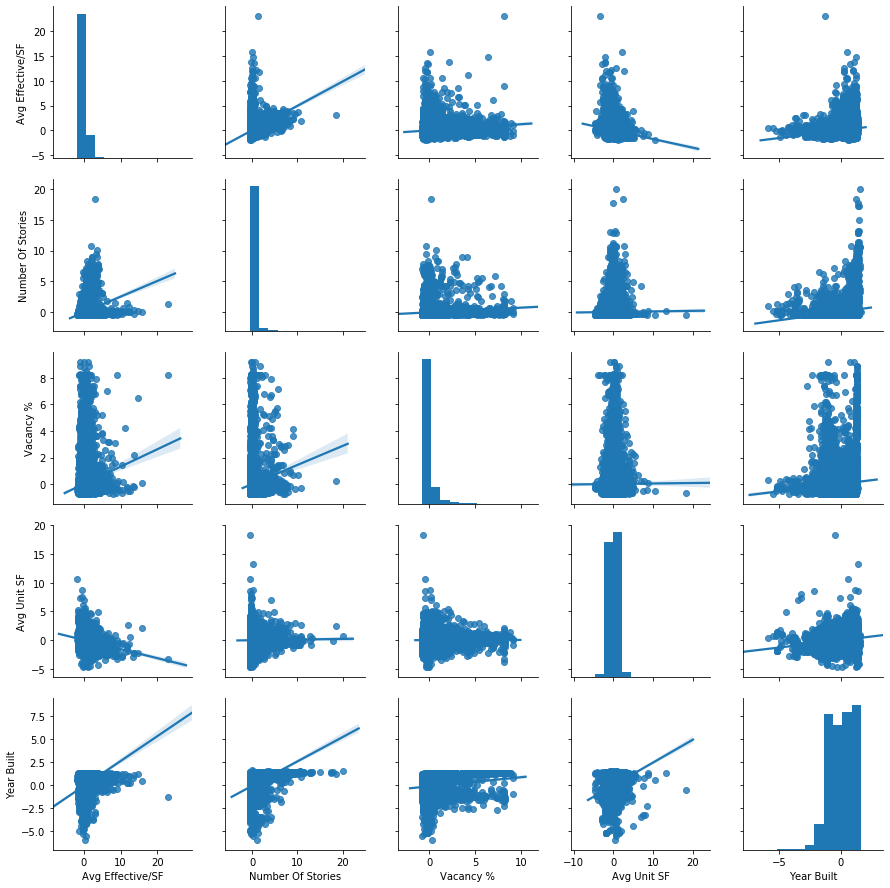

In [42]:
cols = ['Avg Effective/SF', 'Number Of Stories', 'Vacancy %', 'Avg Unit SF', 'Year Built']
scaled_num1 = scaled_numerical[cols]
sns.pairplot(scaled_num1, kind='reg')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


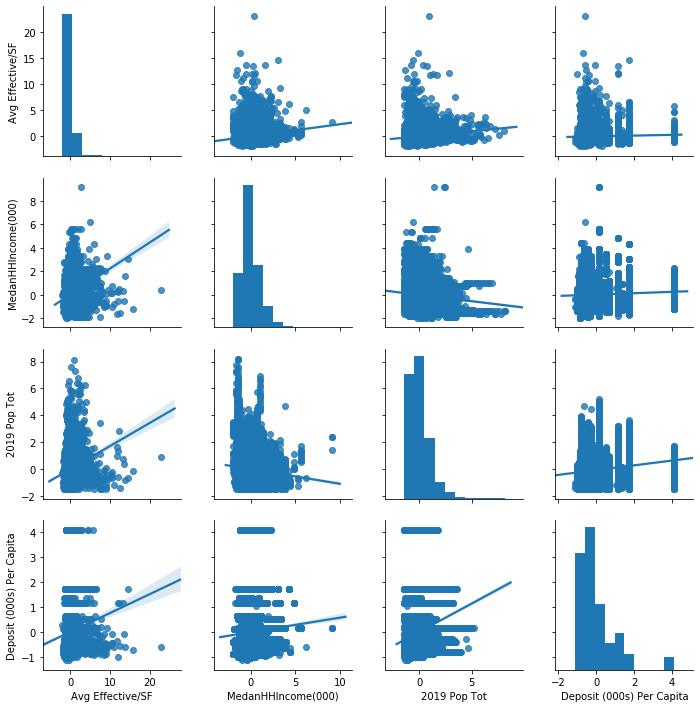

In [43]:
cols = ['Avg Effective/SF', 'MedanHHIncome(000)', '2019 Pop Tot', 'Deposit (000s) Per Capita']
scaled_num3 = scaled_numerical[cols]
sns.pairplot(scaled_num3, kind='reg')

<Figure size 720x432 with 0 Axes>

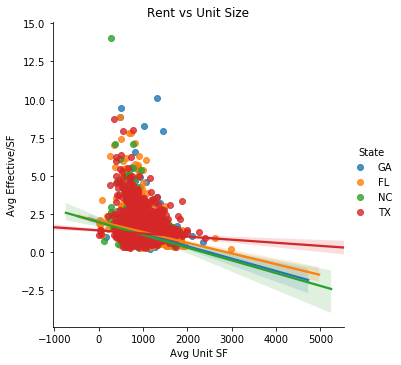

In [44]:
plt.figure(figsize=(10,6))
sns.lmplot('Avg Unit SF', 'Avg Effective/SF', data=sub, 
           fit_reg=True, hue='State', legend=True)
plt.title("Rent vs Unit Size")
plt.show()

<Figure size 720x432 with 0 Axes>

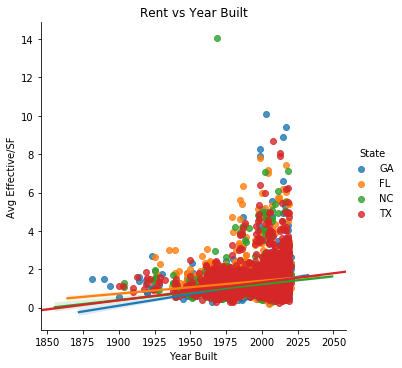

In [45]:
plt.figure(figsize=(10,6))
sns.lmplot('Year Built', 'Avg Effective/SF', data=sub, 
           fit_reg=True, hue='State', legend=True)
plt.title("Rent vs Year Built")
plt.show()